# Session5: Support Vector Machines & Cross-Validation

## Session Overview

1. **Support Vector Machines (SVM)** - A powerful algorithm for both classification and regression tasks
2. **Cross-Validation Methods** - Essential techniques for reliable model evaluation

In [10]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC, SVR
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold,
    LeaveOneOut, TimeSeriesSplit, GroupKFold,
    cross_val_score, GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    mean_squared_error, r2_score, mean_absolute_error
)
from sklearn.datasets import make_classification, make_regression
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

---
## Part 1: Support Vector Machines - The Intuition

### What is an SVM?

Imagine you're trying to separate two groups of EEG patterns (e.g., high arousal vs. low arousal states). A Support Vector Machine doesn't just find any boundary between these groups—it finds the **best** boundary. But what makes a boundary "best"?

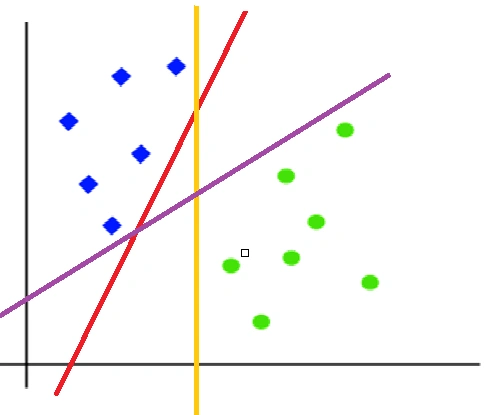

# 1. Maximal Margin Classifier
### The Core Concept: Maximum Margin

Think of SVM as drawing a line (or hyperplane in higher dimensions) between your data classes, but with a special goal: **maximize the margin**. The margin is the distance between the decision boundary and the closest data points from each class. These closest points are called **support vectors**, and they're the only points that actually matter for defining the boundary.

Why maximize the margin? A larger margin means the model is more confident and robust—it's less likely to misclassify new, unseen data that might be slightly different from the training data.

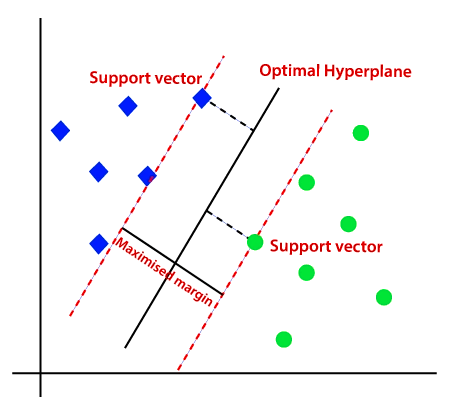

#2. Support Vector Classifier

###Support Vectors:
Support Vector Classifier is an extension of the Maximal Margin Classifier. It is less sensitive to individual data. Since it allows certain data to be misclassified, it’s also known as the “Soft Margin Classifier”. It creates a budget under which the misclassification allowance is granted.

Also, It allows some points to be misclassified, as shown in the following diagram. The points inside the margin and on the margin are referred to as “Support Vectors” in this scenario. Whereas, the points on the margins were referred to as “Support vectors” in the Maximal – Margin Classifier.

 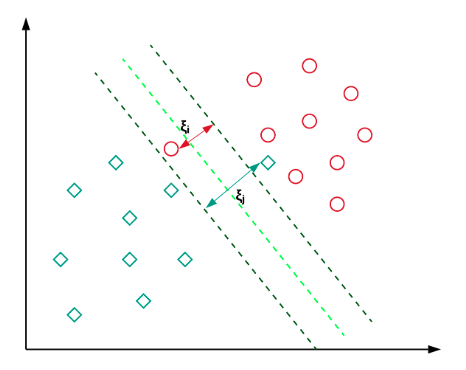


#3. Support Vector Machines

###The Kernel Trick:
Real-world EEG data is rarely linearly separable. This is where kernels come in. A kernel is a mathematical function that transforms your data into a higher-dimensional space where it might become linearly separable. Think of it like this: if you can't separate two groups on a flat piece of paper, maybe you can if you fold that paper into 3D space. The beauty of the kernel trick is that we never actually have to compute these high-dimensional coordinates—the kernel function does it implicitly.

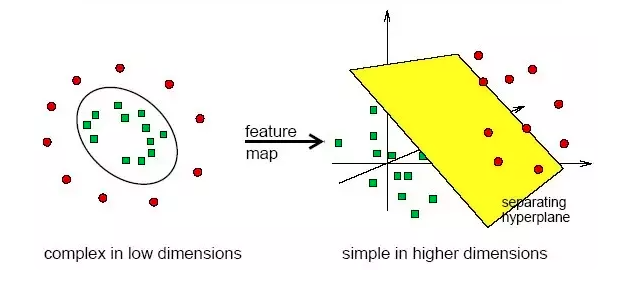

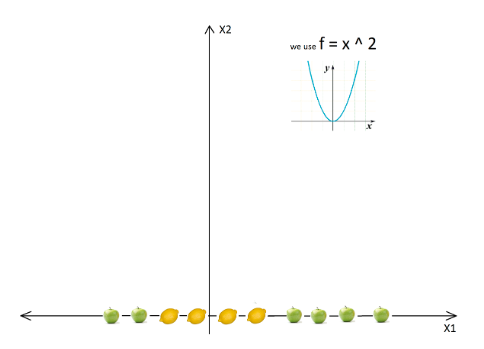

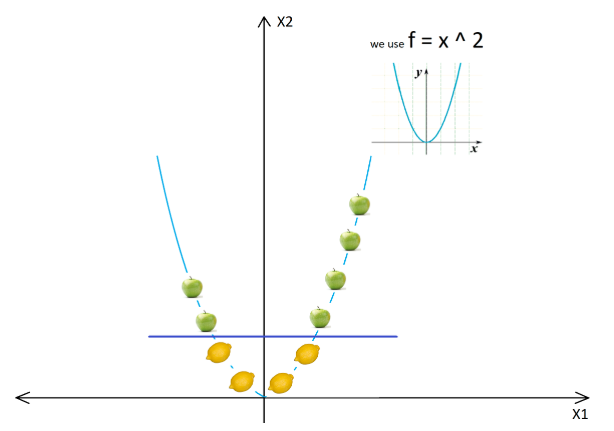


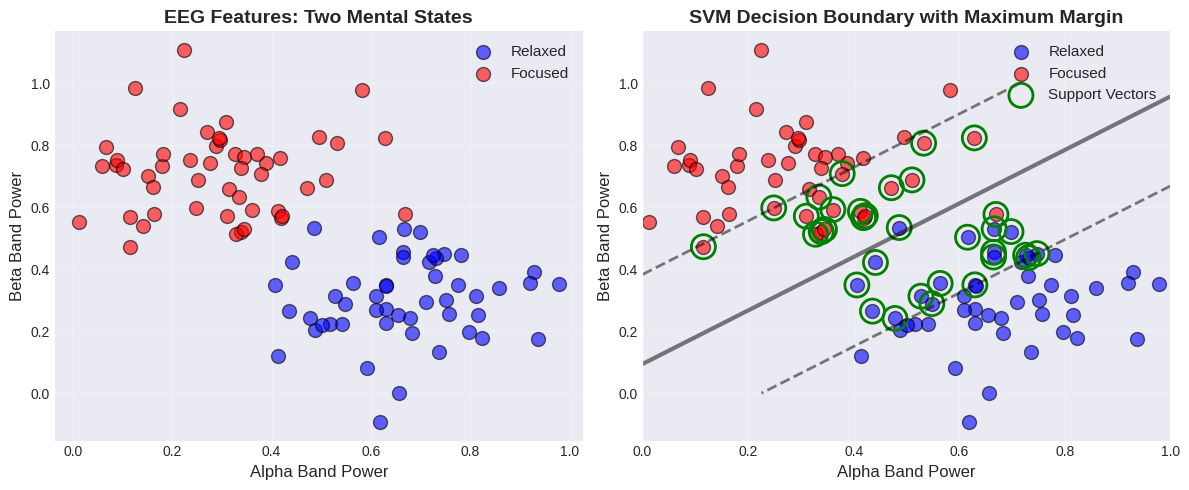

Number of support vectors: 34
Out of 100 total training samples

Notice how only a few points (support vectors) define the entire boundary!


In [13]:
# Generate synthetic EEG band power features for two mental states
# Let's simulate alpha and beta band powers for 'relaxed' vs 'focused' states

np.random.seed(42)

# Relaxed state: higher alpha, lower beta
n_relaxed = 50
alpha_relaxed = np.random.normal(0.7, 0.15, n_relaxed)
beta_relaxed = np.random.normal(0.3, 0.15, n_relaxed)

# Focused state: lower alpha, higher beta
n_focused = 50
alpha_focused = np.random.normal(0.3, 0.15, n_focused)
beta_focused = np.random.normal(0.7, 0.15, n_focused)

# Combine data
X_simple = np.vstack([
    np.column_stack([alpha_relaxed, beta_relaxed]),
    np.column_stack([alpha_focused, beta_focused])
])
y_simple = np.hstack([np.zeros(n_relaxed), np.ones(n_focused)])

# Visualize the data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_simple[y_simple==0, 0], X_simple[y_simple==0, 1],
           c='blue', label='Relaxed', s=100, alpha=0.6, edgecolors='k')
plt.scatter(X_simple[y_simple==1, 0], X_simple[y_simple==1, 1],
           c='red', label='Focused', s=100, alpha=0.6, edgecolors='k')
plt.xlabel('Alpha Band Power', fontsize=12)
plt.ylabel('Beta Band Power', fontsize=12)
plt.title('EEG Features: Two Mental States', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Train a simple linear SVM
svm_simple = SVC(kernel='linear', C=1.0)
svm_simple.fit(X_simple, y_simple)

# Plot decision boundary and margins
plt.subplot(1, 2, 2)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 200)
yy = np.linspace(ylim[0], ylim[1], 200)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svm_simple.decision_function(xy).reshape(XX.shape)

# Plot decision boundary and margins
plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'], linewidths=[2, 3, 2])
plt.scatter(X_simple[y_simple==0, 0], X_simple[y_simple==0, 1],
           c='blue', label='Relaxed', s=100, alpha=0.6, edgecolors='k')
plt.scatter(X_simple[y_simple==1, 0], X_simple[y_simple==1, 1],
           c='red', label='Focused', s=100, alpha=0.6, edgecolors='k')

# Highlight support vectors
plt.scatter(svm_simple.support_vectors_[:, 0],
           svm_simple.support_vectors_[:, 1],
           s=300, linewidth=2, facecolors='none',
           edgecolors='green', label='Support Vectors')

plt.xlabel('Alpha Band Power', fontsize=12)
plt.ylabel('Beta Band Power', fontsize=12)
plt.title('SVM Decision Boundary with Maximum Margin', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Number of support vectors: {len(svm_simple.support_vectors_)}")
print(f"Out of {len(X_simple)} total training samples")
print("\nNotice how only a few points (support vectors) define the entire boundary!")

---
## Part 2: SVM for Classification

We'll create synthetic EEG band power features across multiple channels to classify different cognitive states.

### The Hyperparameter C

Before we proceed, let's understand the **C parameter**. In real-world data, perfect separation is often impossible—some data points will inevitably be on the wrong side of the margin. The C parameter controls the trade-off between achieving a wide margin and correctly classifying training points.

A **small C** creates a wider margin but allows more misclassifications (softer margin). This can help prevent overfitting.

A **large C** tries harder to classify all training points correctly, even if it means a narrower margin (harder margin). This risks overfitting.

Think of C as the "strictness" parameter—how much do you penalize the model for making mistakes?

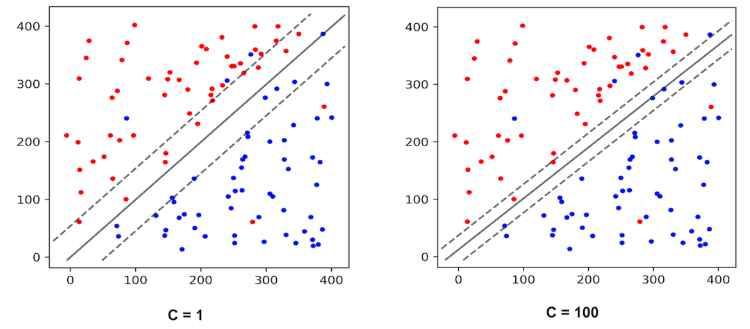

In [14]:
# Create synthetic EEG dataset with multiple band powers and channels
def create_synthetic_eeg_classification(n_samples=300, n_channels=4, random_state=42):
    """
    Creates synthetic EEG band power features for classification.

    Features represent band powers (delta, theta, alpha, beta, gamma)
    from multiple EEG channels for three different mental states:
    0: Relaxed, 1: Focused, 2: Stressed
    """
    np.random.seed(random_state)

    n_bands = 5  # delta, theta, alpha, beta, gamma
    n_per_class = n_samples // 3

    features = []
    labels = []

    # Class 0: Relaxed state (high alpha, moderate theta, low beta)
    for _ in range(n_per_class):
        sample = []
        for ch in range(n_channels):
            delta = np.random.normal(0.15, 0.05)
            theta = np.random.normal(0.25, 0.05)
            alpha = np.random.normal(0.40, 0.08)  # High alpha
            beta = np.random.normal(0.15, 0.05)   # Low beta
            gamma = np.random.normal(0.05, 0.02)
            sample.extend([delta, theta, alpha, beta, gamma])
        features.append(sample)
        labels.append(0)

    # Class 1: Focused state (low alpha, high beta, moderate theta)
    for _ in range(n_per_class):
        sample = []
        for ch in range(n_channels):
            delta = np.random.normal(0.12, 0.04)
            theta = np.random.normal(0.22, 0.05)
            alpha = np.random.normal(0.18, 0.05)  # Low alpha
            beta = np.random.normal(0.38, 0.08)   # High beta
            gamma = np.random.normal(0.10, 0.03)
            sample.extend([delta, theta, alpha, beta, gamma])
        features.append(sample)
        labels.append(1)

    # Class 2: Stressed state (high beta, high gamma, low alpha)
    for _ in range(n_per_class):
        sample = []
        for ch in range(n_channels):
            delta = np.random.normal(0.10, 0.04)
            theta = np.random.normal(0.18, 0.05)
            alpha = np.random.normal(0.15, 0.05)  # Low alpha
            beta = np.random.normal(0.42, 0.08)   # High beta
            gamma = np.random.normal(0.15, 0.04)  # High gamma
            sample.extend([delta, theta, alpha, beta, gamma])
        features.append(sample)
        labels.append(2)

    X = np.array(features)
    y = np.array(labels)

    # Shuffle the data
    idx = np.random.permutation(len(y))
    X, y = X[idx], y[idx]

    return X, y

# Generate dataset
X_eeg, y_eeg = create_synthetic_eeg_classification(n_samples=300, n_channels=4)

print(f"Dataset shape: {X_eeg.shape}")
print(f"Features: {X_eeg.shape[1]} (4 channels × 5 frequency bands)")
print(f"Samples per class: {np.bincount(y_eeg)}")
print("\nClass labels: 0=Relaxed, 1=Focused, 2=Stressed")

Dataset shape: (300, 20)
Features: 20 (4 channels × 5 frequency bands)
Samples per class: [100 100 100]

Class labels: 0=Relaxed, 1=Focused, 2=Stressed


In [15]:
# Split data and standardize features
X_train, X_test, y_train, y_test = train_test_split(
    X_eeg, y_eeg, test_size=0.3, random_state=42, stratify=y_eeg
)

# standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (210, 20)
Test set: (90, 20)


### Exploring Different Kernels



**Linear Kernel:** This assumes your data can be separated by a straight line (or hyperplane). It's the simplest and fastest option. Use it when you have many features relative to samples, or when you believe the relationship is roughly linear.


**Polynomial Kernel:** This creates curved decision boundaries based on polynomial combinations of your features. The degree parameter determines how curvy these boundaries can be. A degree of 2 creates parabolic curves, degree 3 creates more complex curves, and so on.

**RBF (Radial Basis Function) Kernel:** This is the most popular kernel for non-linear problems. It can learn complex, circular decision boundaries.


Training SVMs with different kernels...

Kernel: LINEAR
  Training accuracy: 1.000
  Test accuracy: 0.933
  Number of support vectors: 39
------------------------------------------------------------
Kernel: RBF
  Training accuracy: 0.990
  Test accuracy: 0.956
  Number of support vectors: 93
------------------------------------------------------------
Kernel: POLY
  Training accuracy: 0.990
  Test accuracy: 0.922
  Number of support vectors: 92
------------------------------------------------------------


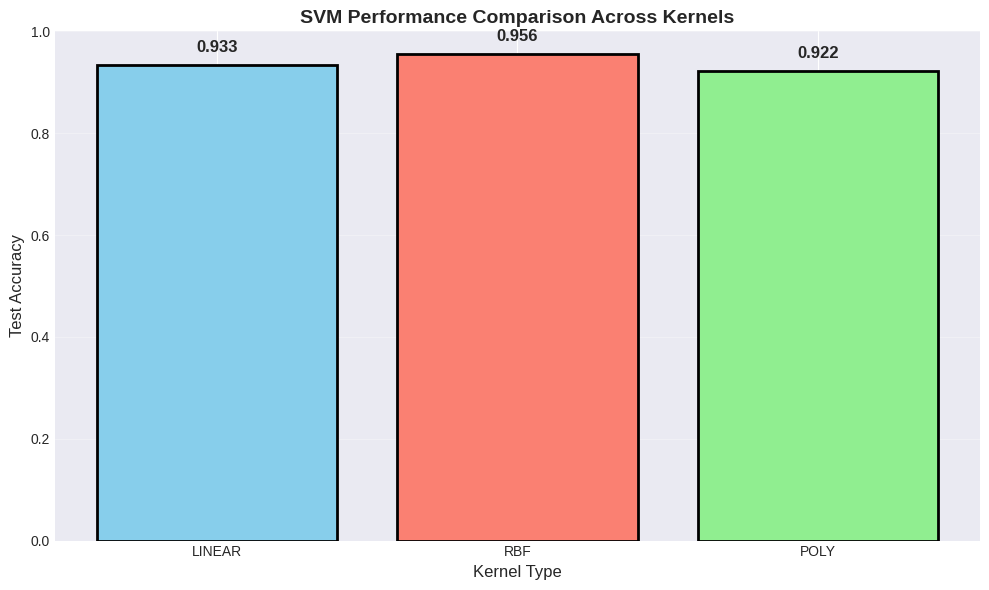

In [19]:
# Compare different SVM kernels
kernels = ['linear', 'rbf', 'poly']
results = {}

print("Training SVMs with different kernels...\n")
print("="*60)

for kernel in kernels:
    # Train SVM with specific kernel
    if kernel == 'poly':
        svm = SVC(kernel=kernel, degree=3, C=1.0, random_state=42)
    else:
        svm = SVC(kernel=kernel, C=1.0, random_state=42)

    svm.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = svm.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)

    results[kernel] = {
        'model': svm,
        'accuracy': accuracy,
        'predictions': y_pred
    }

    print(f"Kernel: {kernel.upper()}")
    print(f"  Training accuracy: {svm.score(X_train_scaled, y_train):.3f}")
    print(f"  Test accuracy: {accuracy:.3f}")
    print(f"  Number of support vectors: {len(svm.support_vectors_)}")
    print("-"*60)

# Visualize comparison
plt.figure(figsize=(10, 6))
kernel_names = [k.upper() for k in kernels]
accuracies = [results[k]['accuracy'] for k in kernels]

bars = plt.bar(kernel_names, accuracies, color=['skyblue', 'salmon', 'lightgreen'],
               edgecolor='black', linewidth=2)
plt.ylim([0, 1.0])
plt.ylabel('Test Accuracy', fontsize=12)
plt.xlabel('Kernel Type', fontsize=12)
plt.title('SVM Performance Comparison Across Kernels', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{acc:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

Best performing kernel: RBF

Classification Report:
              precision    recall  f1-score   support

     Relaxed       1.00      1.00      1.00        30
     Focused       0.93      0.93      0.93        30
    Stressed       0.93      0.93      0.93        30

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90



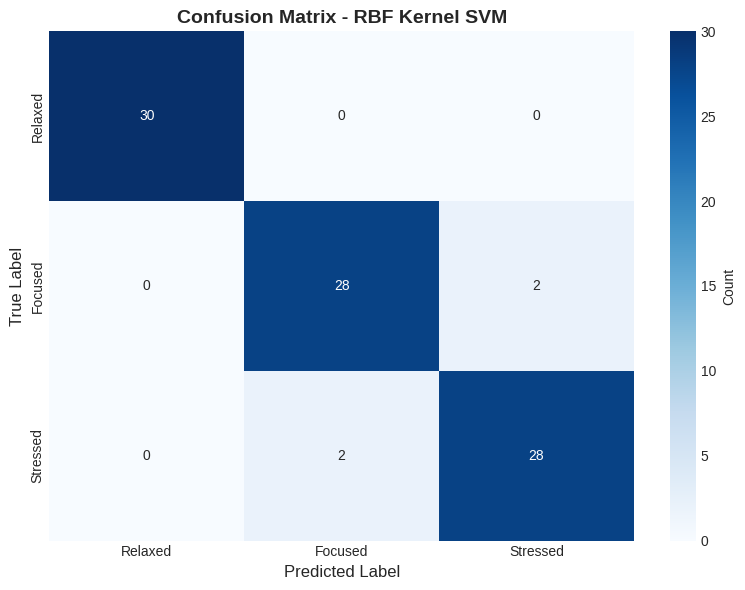

In [6]:
# Detailed analysis of the best performing kernel
best_kernel = max(results, key=lambda k: results[k]['accuracy'])
best_model = results[best_kernel]['model']
best_predictions = results[best_kernel]['predictions']

print(f"Best performing kernel: {best_kernel.upper()}")
print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test, best_predictions,
                          target_names=['Relaxed', 'Focused', 'Stressed']))

# Confusion matrix visualization
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Relaxed', 'Focused', 'Stressed'],
            yticklabels=['Relaxed', 'Focused', 'Stressed'],
            cbar_kws={'label': 'Count'})
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title(f'Confusion Matrix - {best_kernel.upper()} Kernel SVM',
         fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Part 3: SVM for Regression (SVR)

### From Classification to Regression

So far, we've used SVM to classify discrete mental states. But what if we want to predict continuous values, like arousal level or attention score? That's where Support Vector Regression comes in.

### The Key Difference: Epsilon-Tube

While SVM classification tries to maximize the margin between classes, SVR tries to fit as many data points as possible within a tube around the regression line. This tube has a width of epsilon (ε).

Here's the beautiful insight: instead of penalizing all errors, SVR only penalizes predictions that fall **outside** the epsilon-tube. Points inside the tube are considered "good enough" and don't contribute to the loss. This makes SVR robust to small errors and noise.

The support vectors in regression are the points that either lie on the edge of the epsilon-tube or fall outside it. Just like in classification, these are the only points that matter for defining the regression function.

### Key Hyperparameters for SVR:

**Epsilon (ε):** Controls the width of the tube. Larger epsilon means you're more tolerant of errors (simpler model), while smaller epsilon demands more precision (complex model).

**C:** Just like in classification, C controls the trade-off. Here it balances between keeping the tube narrow and tolerating points outside the tube.

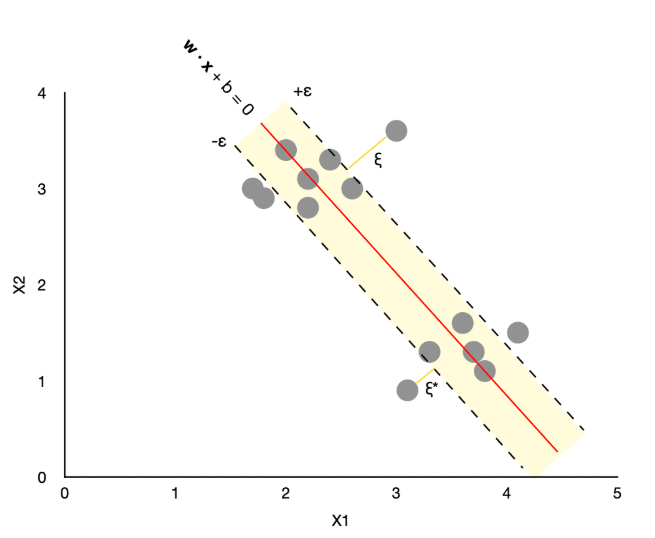

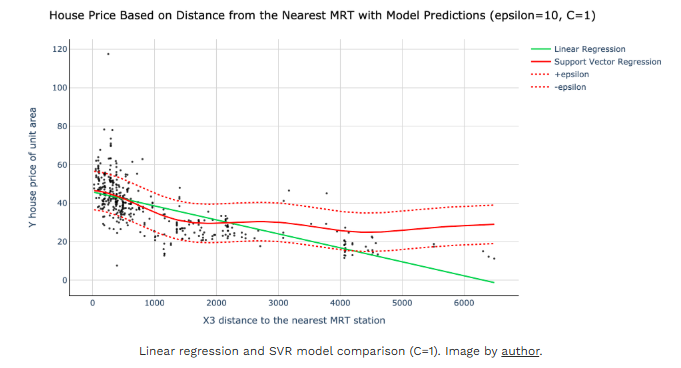

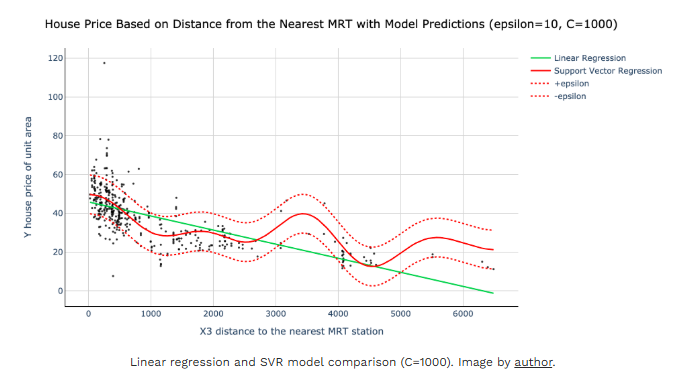

Regression dataset shape: (300, 20)
Target (arousal) range: [5.06, 10.00]
Mean arousal level: 8.35 ± 1.31


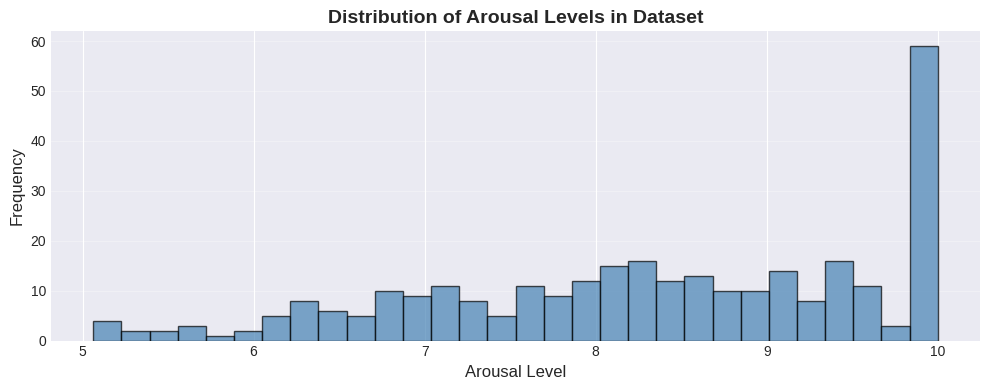

In [7]:
# Create synthetic EEG regression dataset
def create_synthetic_eeg_regression(n_samples=300, n_channels=4, random_state=42):
    """
    Creates synthetic EEG band power features for regression.
    Target: Continuous arousal level (0-10 scale)

    The arousal level depends on:
    - Beta band activity (positive correlation)
    - Alpha band activity (negative correlation)
    - Gamma band activity (positive correlation)
    """
    np.random.seed(random_state)

    n_bands = 5
    features = []
    arousal_levels = []

    for _ in range(n_samples):
        sample = []
        beta_sum = 0
        alpha_sum = 0
        gamma_sum = 0

        for ch in range(n_channels):
            delta = np.random.normal(0.15, 0.05)
            theta = np.random.normal(0.20, 0.05)
            alpha = np.random.normal(0.25, 0.10)
            beta = np.random.normal(0.25, 0.10)
            gamma = np.random.normal(0.10, 0.05)

            sample.extend([delta, theta, alpha, beta, gamma])
            beta_sum += beta
            alpha_sum += alpha
            gamma_sum += gamma

        # Arousal is influenced by beta (+), alpha (-), and gamma (+)
        arousal = (3 * beta_sum - 2 * alpha_sum + 2 * gamma_sum) * 2 + 5
        arousal += np.random.normal(0, 0.5)  # Add some noise
        arousal = np.clip(arousal, 0, 10)  # Keep in valid range

        features.append(sample)
        arousal_levels.append(arousal)

    return np.array(features), np.array(arousal_levels)

# Generate regression dataset
X_reg, y_reg = create_synthetic_eeg_regression(n_samples=300, n_channels=4)

print(f"Regression dataset shape: {X_reg.shape}")
print(f"Target (arousal) range: [{y_reg.min():.2f}, {y_reg.max():.2f}]")
print(f"Mean arousal level: {y_reg.mean():.2f} ± {y_reg.std():.2f}")

# Visualize arousal distribution
plt.figure(figsize=(10, 4))
plt.hist(y_reg, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('Arousal Level', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Arousal Levels in Dataset', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
# Prepare data for SVR
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

# Standardize features
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Train SVR models with different kernels
svr_results = {}

print("Training SVR models with different kernels...\n")
print("="*60)

for kernel in ['linear', 'rbf', 'poly']:
    if kernel == 'poly':
        svr = SVR(kernel=kernel, degree=3, C=1.0, epsilon=0.1)
    else:
        svr = SVR(kernel=kernel, C=1.0, epsilon=0.1)

    svr.fit(X_train_reg_scaled, y_train_reg)
    y_pred_reg = svr.predict(X_test_reg_scaled)

    # Calculate regression metrics
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_reg, y_pred_reg)
    r2 = r2_score(y_test_reg, y_pred_reg)

    svr_results[kernel] = {
        'model': svr,
        'predictions': y_pred_reg,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    print(f"Kernel: {kernel.upper()}")
    print(f"  RMSE: {rmse:.3f}")
    print(f"  MAE: {mae:.3f}")
    print(f"  R² Score: {r2:.3f}")
    print(f"  Number of support vectors: {len(svr.support_vectors_)}")
    print("-"*60)

Training SVR models with different kernels...

Kernel: LINEAR
  RMSE: 0.530
  MAE: 0.433
  R² Score: 0.842
  Number of support vectors: 179
------------------------------------------------------------
Kernel: RBF
  RMSE: 0.793
  MAE: 0.629
  R² Score: 0.647
  Number of support vectors: 184
------------------------------------------------------------
Kernel: POLY
  RMSE: 0.938
  MAE: 0.779
  R² Score: 0.506
  Number of support vectors: 191
------------------------------------------------------------


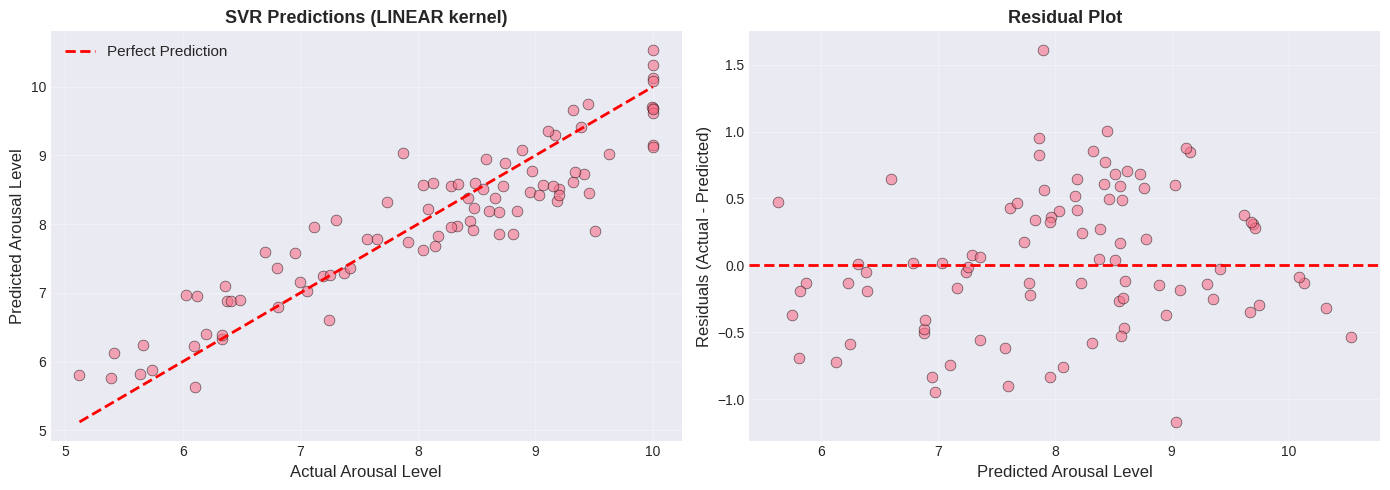


Best SVR kernel: LINEAR
R² Score: 0.842
RMSE: 0.530


In [27]:
# Visualize SVR predictions
best_svr_kernel = max(svr_results, key=lambda k: svr_results[k]['r2'])
best_svr_pred = svr_results[best_svr_kernel]['predictions']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Predicted vs Actual
axes[0].scatter(y_test_reg, best_svr_pred, alpha=0.6, s=60,
               edgecolors='k', linewidth=0.5)
axes[0].plot([y_test_reg.min(), y_test_reg.max()],
            [y_test_reg.min(), y_test_reg.max()],
            'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Arousal Level', fontsize=12)
axes[0].set_ylabel('Predicted Arousal Level', fontsize=12)
axes[0].set_title(f'SVR Predictions ({best_svr_kernel.upper()} kernel)',
                 fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test_reg - best_svr_pred
axes[1].scatter(best_svr_pred, residuals, alpha=0.6, s=60,
               edgecolors='k', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Arousal Level', fontsize=12)
axes[1].set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest SVR kernel: {best_svr_kernel.upper()}")
print(f"R² Score: {svr_results[best_svr_kernel]['r2']:.3f}")
print(f"RMSE: {svr_results[best_svr_kernel]['rmse']:.3f}")

---
## Part 4: Cross-Validation

### The Problem with Single Train-Test Splits

So far, we've been using a single train-test split to evaluate our models. But here's the issue: what if our test set happened to contain unusually easy or unusually hard examples? Our accuracy estimate might not reflect the model's true performance on new data.


### What is Cross-Validation?

Cross-validation is a technique that addresses this problem by testing your model on multiple different subsets of data. Instead of one train-test split, you perform multiple splits, train and test on each, and then average the results. This gives you a more reliable estimate of how your model will perform on truly unseen data.


### 1. K-Fold Cross-Validation

This is the most common approach. You split your data into K equal-sized folds. Then, you train on K-1 folds and test on the remaining fold. You repeat this K times, each time using a different fold as the test set.

The key advantage is that every data point gets to be in the test set exactly once, and you use almost all your data for training in each iteration.

Common choices for K are 5 or 10. Why? A smaller K means more test data in each training set but fewer iterations (less stable estimate). A larger K means less data in each training set but more iterations (more stable estimate). Five to ten folds typically strikes a good balance.

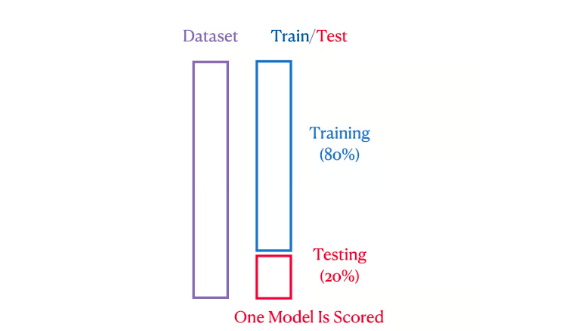

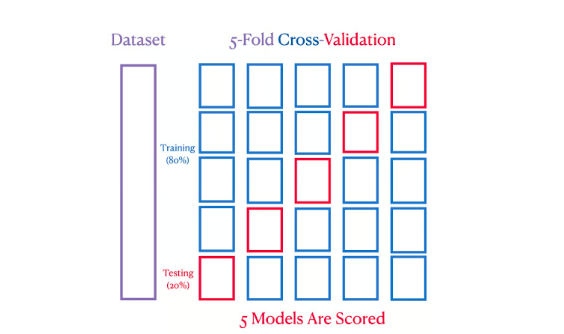

In [32]:
# K-Fold Cross-Validation demonstration
from sklearn.model_selection import cross_validate

# Let's use our EEG classification data
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)

# Define different K values to compare
k_values = [3, 5, 10]

print("K-Fold Cross-Validation Comparison\n")
print("="*70)

kfold_results = {}

for k in k_values:
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)

    # cross_validate returns multiple metrics
    cv_results = cross_validate(
        svm_model, X_eeg, y_eeg,
        cv=kfold,
        scoring='accuracy',
        return_train_score=True
    )

    kfold_results[k] = cv_results

    print(f"\n{k}-Fold Cross-Validation:")
    print(f"  Mean Train Accuracy: {cv_results['train_score'].mean():.3f} (±{cv_results['train_score'].std():.3f})")
    print(f"  Mean Test Accuracy:  {cv_results['test_score'].mean():.3f} (±{cv_results['test_score'].std():.3f})")
    print(f"  Individual fold scores: {[f'{s:.3f}' for s in cv_results['test_score']]}")

print("\n" + "="*70)
print("Notice how the standard deviation gives us confidence in our estimate!")
print("A smaller std means more consistent performance across folds.")

K-Fold Cross-Validation Comparison


3-Fold Cross-Validation:
  Mean Train Accuracy: 0.982 (±0.006)
  Mean Test Accuracy:  0.970 (±0.016)
  Individual fold scores: ['0.950', '0.990', '0.970']

5-Fold Cross-Validation:
  Mean Train Accuracy: 0.982 (±0.005)
  Mean Test Accuracy:  0.970 (±0.016)
  Individual fold scores: ['0.983', '0.950', '0.983', '0.983', '0.950']

10-Fold Cross-Validation:
  Mean Train Accuracy: 0.983 (±0.005)
  Mean Test Accuracy:  0.977 (±0.030)
  Individual fold scores: ['1.000', '0.967', '0.900', '1.000', '0.967', '1.000', '1.000', '0.967', '0.967', '1.000']

Notice how the standard deviation gives us confidence in our estimate!
A smaller std means more consistent performance across folds.


### 2. Stratified K-Fold Cross-Validation

Regular K-Fold has a potential problem: what if your classes are imbalanced, or what if by chance one fold ends up with mostly one class? This is where Stratified K-Fold comes in.

Stratified K-Fold ensures that each fold has approximately the same proportion of samples from each class as the complete dataset. This is crucial for EEG classification tasks where you might have imbalanced classes (for example, if seizure events are rare compared to normal brain activity).

The rule of thumb: **always use Stratified K-Fold for classification problems** unless you have a specific reason not to.

In [33]:
# Compare K-Fold vs Stratified K-Fold
print("Comparing K-Fold vs Stratified K-Fold\n")
print("="*70)

# Create imbalanced dataset to demonstrate the difference
# Take more samples from relaxed state
relaxed_idx = np.where(y_eeg == 0)[0][:110]
focused_idx = np.where(y_eeg == 1)[0][:10]
stressed_idx = np.where(y_eeg == 2)[0][:10]

imbalanced_idx = np.concatenate([relaxed_idx, focused_idx, stressed_idx])
X_imbalanced = X_eeg[imbalanced_idx]
y_imbalanced = y_eeg[imbalanced_idx]

print(f"Imbalanced dataset class distribution:")
for cls in range(3):
    count = np.sum(y_imbalanced == cls)
    pct = 100 * count / len(y_imbalanced)
    print(f"  Class {cls}: {count} samples ({pct:.1f}%)")

# Regular K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
print("\nRegular K-Fold - Class distribution per fold:")
for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X_imbalanced)):
    test_dist = np.bincount(y_imbalanced[test_idx].astype(int), minlength=3)
    print(f"  Fold {fold_idx+1}: {test_dist}")

# Stratified K-Fold
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\nStratified K-Fold - Class distribution per fold:")
for fold_idx, (train_idx, test_idx) in enumerate(skfold.split(X_imbalanced, y_imbalanced)):
    test_dist = np.bincount(y_imbalanced[test_idx].astype(int), minlength=3)
    print(f"  Fold {fold_idx+1}: {test_dist}")

print("\n" + "="*70)
print("Notice how Stratified K-Fold maintains class proportions!")
print("This leads to more reliable performance estimates.")

# Compare performance
cv_regular = cross_val_score(svm_model, X_imbalanced, y_imbalanced,
                            cv=kfold, scoring='accuracy')
cv_stratified = cross_val_score(svm_model, X_imbalanced, y_imbalanced,
                               cv=skfold, scoring='accuracy')

print(f"\nRegular K-Fold:    {cv_regular.mean():.3f} (±{cv_regular.std():.3f})")
print(f"Stratified K-Fold: {cv_stratified.mean():.3f} (±{cv_stratified.std():.3f})")

Comparing K-Fold vs Stratified K-Fold

Imbalanced dataset class distribution:
  Class 0: 100 samples (83.3%)
  Class 1: 10 samples (8.3%)
  Class 2: 10 samples (8.3%)

Regular K-Fold - Class distribution per fold:
  Fold 1: [21  3  0]
  Fold 2: [21  0  3]
  Fold 3: [21  1  2]
  Fold 4: [19  2  3]
  Fold 5: [18  4  2]

Stratified K-Fold - Class distribution per fold:
  Fold 1: [20  2  2]
  Fold 2: [20  2  2]
  Fold 3: [20  2  2]
  Fold 4: [20  2  2]
  Fold 5: [20  2  2]

Notice how Stratified K-Fold maintains class proportions!
This leads to more reliable performance estimates.

Regular K-Fold:    0.958 (±0.026)
Stratified K-Fold: 0.975 (±0.033)


### 3. Leave-One-Out Cross-Validation (LOOCV)

LOOCV is an extreme case of K-Fold where K equals the number of samples. In each iteration, you train on all samples except one, and test on that single held-out sample.

**Advantages:** You use the maximum possible amount of training data in each iteration, which can be beneficial when you have very limited data.

**Disadvantages:** It's computationally expensive (you train N models where N is your sample size) and can have high variance in the performance estimate because each test set is just one sample.

For EEG analysis, LOOCV is most useful when you have very few subjects and want to maximize your training data, but be aware of the computational cost.

In [34]:
# Leave-One-Out Cross-Validation demonstration
# We'll use a smaller subset for computational efficiency
n_samples_loo = 100
X_loo = X_eeg[:n_samples_loo]
y_loo = y_eeg[:n_samples_loo]

print("Leave-One-Out Cross-Validation\n")
print("="*70)
print(f"Dataset size: {n_samples_loo} samples")
print(f"This means we'll train {n_samples_loo} models!\n")

# LOO CV
loo = LeaveOneOut()
import time
start_time = time.time()
cv_loo = cross_val_score(svm_model, X_loo, y_loo, cv=loo, scoring='accuracy')
loo_time = time.time() - start_time

# Compare with 10-Fold
kfold_10 = KFold(n_splits=10, shuffle=True, random_state=42)
start_time = time.time()
cv_kfold = cross_val_score(svm_model, X_loo, y_loo, cv=kfold_10, scoring='accuracy')
kfold_time = time.time() - start_time

print(f"LOOCV Results:")
print(f"  Mean Accuracy: {cv_loo.mean():.3f} (±{cv_loo.std():.3f})")
print(f"  Computation Time: {loo_time:.2f} seconds")
print(f"  Number of iterations: {len(cv_loo)}")

print(f"\n10-Fold CV Results:")
print(f"  Mean Accuracy: {cv_kfold.mean():.3f} (±{cv_kfold.std():.3f})")
print(f"  Computation Time: {kfold_time:.2f} seconds")
print(f"  Number of iterations: {len(cv_kfold)}")

print(f"\nSpeed difference: LOOCV is {loo_time/kfold_time:.1f}x slower")
print("\nTakeaway: LOOCV gives similar accuracy but is much more expensive.")
print("Use it only when you have very small datasets!")

Leave-One-Out Cross-Validation

Dataset size: 100 samples
This means we'll train 100 models!

LOOCV Results:
  Mean Accuracy: 0.980 (±0.140)
  Computation Time: 0.33 seconds
  Number of iterations: 100

10-Fold CV Results:
  Mean Accuracy: 0.980 (±0.040)
  Computation Time: 0.03 seconds
  Number of iterations: 10

Speed difference: LOOCV is 10.9x slower

Takeaway: LOOCV gives similar accuracy but is much more expensive.
Use it only when you have very small datasets!


### 4. Time Series Cross-Validation

Regular K-Fold randomly shuffles data, but **EEG data has temporal dependencies**. What happened a second ago can influence what's happening now.

If we randomly mix time points between training and testing, we're essentially letting our model "peek into the future," which inflates our performance estimates artificially.

Time Series CV respects the temporal order of your data. The training set always contains data from earlier time points, and the test set contains data from later time points. This simulates the real-world scenario where you train on past data and predict future events.

**Critical for EEG:** Use Time Series CV when your data comes from continuous recordings or when you want to predict future brain states based on past patterns.

In [37]:
# Generate time-series EEG data (simulating continuous recording)
def create_temporal_eeg_data(n_timepoints=200, n_features=20):
    """
    Simulates continuous EEG recording with temporal dependencies.
    """
    np.random.seed(42)
    X = np.zeros((n_timepoints, n_features))
    y = np.zeros(n_timepoints)

    # Create temporally correlated features
    for t in range(n_timepoints):
        if t == 0:
            X[t] = np.random.randn(n_features)
        else:
            # Each timepoint is correlated with previous timepoint
            X[t] = 0.7 * X[t-1] + 0.3 * np.random.randn(n_features)

        # State changes gradually over time
        y[t] = 1 if (t > 60 and t < 140) else 0

    return X, y

# Increase n_timepoints to ensure larger test sets in TimeSeriesSplit
X_ts, y_ts = create_temporal_eeg_data(n_timepoints=500)

print("Time Series Cross-Validation for EEG\n")
print("="*70)

# Regular K-Fold (WRONG for time series!)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_regular = cross_val_score(svm_model, X_ts, y_ts, cv=kfold, scoring='accuracy')

# Time Series Split (CORRECT for time series!)
tscv = TimeSeriesSplit(n_splits=5)
cv_timeseries = cross_val_score(svm_model, X_ts, y_ts, cv=tscv, scoring='accuracy')

print("Regular K-Fold (inappropriate):")
print(f"  Mean Accuracy: {cv_regular.mean():.3f} (±{cv_regular.std():.3f})")
print("  ⚠️  This is INFLATED because model sees future data!\n")

print("Time Series Split (appropriate):")
print(f"  Mean Accuracy: {cv_timeseries.mean():.3f} (±{cv_timeseries.std():.3f})")
print("  ✅ This gives realistic performance estimate!\n")

print("="*70)
print("Key Takeaway: For temporal EEG data, always use TimeSeriesSplit!")
print("Regular K-Fold will give you overly optimistic results.")

Time Series Cross-Validation for EEG

Regular K-Fold (inappropriate):
  Mean Accuracy: 0.878 (±0.032)
  ⚠️  This is INFLATED because model sees future data!

Time Series Split (appropriate):
  Mean Accuracy: 0.761 (±0.235)
  ✅ This gives realistic performance estimate!

Key Takeaway: For temporal EEG data, always use TimeSeriesSplit!
Regular K-Fold will give you overly optimistic results.


### 5. Group K-Fold Cross-Validation

 **Group K-Fold** ensures that data from the same subject (or session, or recording) never appears in both training and test sets simultaneously.

Why is this crucial? for example if you train on some trials from Subject A and test on other trials from the same subject, your model might just be learning to recognize Subject A's brain patterns rather than the general mental state you're trying to classify.

Group K-Fold prevents this "data leakage" by keeping all data from each group together in either training or test sets for each fold.

**Critical for EEG:** Always use Group K-Fold when you have multiple subjects and want your model to generalize to new, unseen subjects.

In [39]:
# Generate multi-subject EEG data
def create_multi_subject_eeg_data(n_subjects=10, n_trials_per_subject=30, n_features=20):
    """
    Creates synthetic EEG data from multiple subjects.
    Each subject has unique characteristics.
    """
    np.random.seed(42)

    X = []
    y = []
    groups = []  # Subject IDs

    for subject_id in range(n_subjects):
        # Each subject has unique baseline characteristics
        subject_bias = np.random.randn(n_features) * 0.3

        for trial in range(n_trials_per_subject):
            # Generate features with subject-specific bias
            base_features = np.random.randn(n_features) * 0.5
            features = base_features + subject_bias

            # Label depends on trial condition (0 or 1)
            label = trial % 2

            # Add condition-specific effect
            if label == 1:
                features[:5] += 0.5  # First 5 features change during task

            X.append(features)
            y.append(label)
            groups.append(subject_id)

    return np.array(X), np.array(y), np.array(groups)

# Generate multi-subject data
X_multi, y_multi, groups = create_multi_subject_eeg_data()

print("Group K-Fold Cross-Validation for Multi-Subject EEG\n")
print("="*70)
print(f"Dataset: {len(groups)} trials from {len(np.unique(groups))} subjects")
print(f"Trials per subject: {len(groups) // len(np.unique(groups))}")
print(f"Class distribution: {np.bincount(y_multi)}")

# Regular K-Fold (WRONG for multi-subject data!)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_regular = cross_val_score(svm_model, X_multi, y_multi, cv=kfold, scoring='accuracy')

# Group K-Fold (CORRECT for multi-subject data!)
group_kfold = GroupKFold(n_splits=5)
cv_group = cross_val_score(svm_model, X_multi, y_multi, groups=groups, cv=group_kfold, scoring='accuracy')

print("\nRegular K-Fold (inappropriate):")
print(f"  Mean Accuracy: {cv_regular.mean():.3f} (±{cv_regular.std():.3f})")
print("  ⚠️  This is INFLATED due to subject leakage!\n")

print("Group K-Fold (appropriate):")
print(f"  Mean Accuracy: {cv_group.mean():.3f} (±{cv_group.std():.3f})")
print("  ✅ This shows true generalization to new subjects!\n")

print("="*70)
print("Key Takeaway: For multi-subject EEG studies, always use GroupKFold!")
print("Regular K-Fold will give you misleadingly high accuracy.")


Group K-Fold Cross-Validation for Multi-Subject EEG

Dataset: 300 trials from 10 subjects
Trials per subject: 30
Class distribution: [150 150]

Regular K-Fold (inappropriate):
  Mean Accuracy: 0.790 (±0.029)
  ⚠️  This is INFLATED due to subject leakage!

Group K-Fold (appropriate):
  Mean Accuracy: 0.733 (±0.082)
  ✅ This shows true generalization to new subjects!

Key Takeaway: For multi-subject EEG studies, always use GroupKFold!
Regular K-Fold will give you misleadingly high accuracy.


---
## Part 5: Hyperparameter Tuning with Cross-Validation

### The Need for Hyperparameter Tuning

SVMs have several important hyperparameters that need to be tuned:
- **C**: The regularization parameter
- **degree**: For polynomial kernel
- **epsilon**: For SVR

Finding the right combination is crucial for optimal performance.

### Grid Search with Cross-Validation

GridSearchCV systematically works through multiple parameter combinations, using cross-validation to evaluate each combination's performance. This ensures we find the best parameters without peeking at our test data.

In [41]:
# Hyperparameter tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV

print("Hyperparameter Tuning with GridSearchCV\n")
print("="*70)

# Define parameter grid for SVM
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear','rbf', 'poly']
}

# Set up GridSearchCV with stratified K-fold
grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Fit on training data only
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.3f}")

# Evaluate on test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test_scaled, y_test)
print(f"Test set accuracy: {test_accuracy:.3f}")

# Compare with default parameters
default_model = SVC(kernel='rbf', C=1.0, random_state=42)
default_model.fit(X_train_scaled, y_train)
default_accuracy = default_model.score(X_test_scaled, y_test)
print(f"Default model test accuracy: {default_accuracy:.3f}")


Hyperparameter Tuning with GridSearchCV

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best parameters: {'C': 0.01, 'kernel': 'rbf'}
Best cross-validation accuracy: 0.981
Test set accuracy: 0.956
Default model test accuracy: 0.956

Improvement: +0.000


---
## Part 6: Best Practices for EEG Analysis

### Putting It All Together

Now that we've covered SVMs and various cross-validation techniques, let's summarize the best practices specifically for EEG analysis:

### 1. Choose the Right Cross-Validation Strategy

- **Single subject, continuous recording**: Use TimeSeriesSplit
- **Multiple subjects, generalization goal**: Use GroupKFold
- **Imbalanced classes**: Use StratifiedKFold
- **Small dataset**: Consider LOOCV but be aware of computational cost


### 2. Hyperparameter Tuning

- Use GridSearchCV with appropriate cross-validation
- Start with a wide parameter grid, then refine
- Consider computational constraints

Comprehensive Example: Multi-Subject EEG Classification

Training: 400 trials from 10 subjects
Testing: 200 trials from 5 subjects

Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV accuracy: 0.818
Test accuracy on unseen subjects: 0.820

Classification Report on Test Subjects:
              precision    recall  f1-score   support

     Class 0       0.85      0.78      0.81       100
     Class 1       0.80      0.86      0.83       100

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200



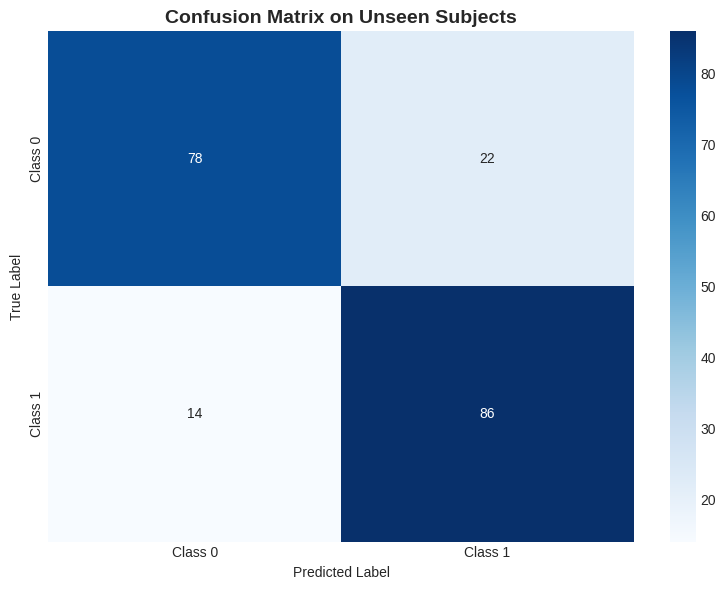


This example demonstrates proper evaluation for EEG studies:
1. Subjects are kept separate between train/test
2. GroupKFold prevents subject leakage during CV
3. Hyperparameter tuning respects group structure
4. Final evaluation is on completely unseen subjects
5. Results reflect true generalization performance


In [42]:
# Comprehensive example: Multi-subject EEG classification with best practices
print("Comprehensive Example: Multi-Subject EEG Classification\n")
print("="*70)

# 1. Generate multi-subject data
X_comp, y_comp, groups_comp = create_multi_subject_eeg_data(
    n_subjects=15, n_trials_per_subject=40, n_features=30
)

# 2. Split data into train/test (keeping subjects separate)
unique_subjects = np.unique(groups_comp)
train_subjects = unique_subjects[:10]  # First 10 subjects for training
test_subjects = unique_subjects[10:]  # Last 5 subjects for testing

train_mask = np.isin(groups_comp, train_subjects)
test_mask = np.isin(groups_comp, test_subjects)

X_train_comp = X_comp[train_mask]
y_train_comp = y_comp[train_mask]
groups_train_comp = groups_comp[train_mask]

X_test_comp = X_comp[test_mask]
y_test_comp = y_comp[test_mask]
groups_test_comp = groups_comp[test_mask]

print(f"Training: {len(X_train_comp)} trials from {len(train_subjects)} subjects")
print(f"Testing: {len(X_test_comp)} trials from {len(test_subjects)} subjects")

# 3. Standardize features
scaler_comp = StandardScaler()
X_train_comp_scaled = scaler_comp.fit_transform(X_train_comp)
X_test_comp_scaled = scaler_comp.transform(X_test_comp)

# 4. Hyperparameter tuning with GroupKFold
param_grid_comp = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']
}

grid_search_comp = GridSearchCV(
    SVC(random_state=42),
    param_grid_comp,
    cv=GroupKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1
)

grid_search_comp.fit(X_train_comp_scaled, y_train_comp, groups=groups_train_comp)

print(f"\nBest parameters: {grid_search_comp.best_params_}")
print(f"Best CV accuracy: {grid_search_comp.best_score_:.3f}")

# 5. Evaluate on completely unseen subjects
best_model_comp = grid_search_comp.best_estimator_
test_accuracy_comp = best_model_comp.score(X_test_comp_scaled, y_test_comp)
print(f"Test accuracy on unseen subjects: {test_accuracy_comp:.3f}")

# 6. Detailed evaluation
y_pred_comp = best_model_comp.predict(X_test_comp_scaled)
print("\nClassification Report on Test Subjects:")
print(classification_report(y_test_comp, y_pred_comp, target_names=['Class 0', 'Class 1']))

# 7. Confusion matrix
cm_comp = confusion_matrix(y_test_comp, y_pred_comp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_comp, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix on Unseen Subjects', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("This example demonstrates proper evaluation for EEG studies:")
print("1. Subjects are kept separate between train/test")
print("2. GroupKFold prevents subject leakage during CV")
print("3. Hyperparameter tuning respects group structure")
print("4. Final evaluation is on completely unseen subjects")
print("5. Results reflect true generalization performance")

---
---
# 🎯 Mini-Project: DEAP Arousal Prediction

## Project Overview

**Objective:** Build and evaluate machine learning models to predict arousal levels from EEG features using the DEAP dataset.


**Tasks:** You will implement both classification and regression models to predict arousal, using appropriate cross-validation strategies and comparing different SVM configurations.

---
## Part 1: Classification Task
Convert continuous arousal ratings into categorical labels. Define three classes: Low Arousal (ratings 1-3), Medium Arousal (ratings 4-6), High Arousal (ratings 7-9).

Implement SVM classifiers with different kernels (linear, RBF, polynomial) using different parameters. Use Stratified K-Fold cross-validation for evaluation. Report accuracy, precision, recall, and F1-score for each kernel. Include confusion matrices for the best performing kernel.

---
## Part 2: Regression Task
Implement Support Vector Regression models with different kernels (linear, RBF, polynomial) using defferent parameters. Use cross-validation for evaluation. Report RMSE, MAE, and R² score for each kernel. Create scatter plots of predicted vs actual arousal for the best kernel.

